In [1]:
import fitdecode
import pandas as pd
import seaborn
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
%matplotlib inline

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
src_file = "C:\\Users\meclijda\Downloads\Karoo-Antwerpen-May-31-2020-092605.fit"

with fitdecode.FitReader(src_file) as fit:
    data = []
    recordcounter = 1
    for frame in fit:
        # The yielded frame object is of one of the following types:
        # * fitdecode.FitHeader
        # * fitdecode.FitDefinitionMessage
        # * fitdecode.FitDataMessage
        # * fitdecode.FitCRC

        if isinstance(frame, fitdecode.FitDataMessage):
            # Here, frame is a FitDataMessage object.
            # A FitDataMessage object contains decoded values that
            # are directly usable in your script logic.
            #print(frame.name, recordcounter)
            if (frame.name == "record"):
                colnames = []
                rowdata = []
                recordcounter += 1
            for i in range(7):
                for field in frame.get_fields(i):
                    #print("  ",field.name,field.value,field.raw_value,field.units)
                    if (frame.name == "record"):
                        colnames.append(str(field.name)+"_"+str(field.units))
                        rowdata.append(field.value)
            if (frame.name == "record"):
                if len(rowdata)==7:
                    data.append(rowdata)


In [4]:
colnames

['position_lat_semicircles',
 'position_long_semicircles',
 'altitude_m',
 'heart_rate_bpm',
 'cadence_rpm',
 'distance_m',
 'speed_m/s']

In [5]:
df = pd.DataFrame(data,columns=colnames)
df.head()

,position_lat_semicircles,position_long_semicircles,altitude_m,heart_rate_bpm,cadence_rpm,distance_m,speed_m/s
0,607296206,55516389,29.6,103,82,7.64,7.085
1,607295450,55516707,29.6,103,82,14.93,7.362
2,607294655,55517025,29.6,104,82,22.58,7.481
3,607293840,55517443,29.6,104,83,30.57,7.541
4,607293025,55517821,29.2,104,84,38.49,7.628


In [6]:
df['speed_km/h'] = df['speed_m/s']*3.6
df['distance_km'] = df['distance_m']/1000
df['position_lat_degrees'] = df['position_lat_semicircles']*180/(2**31)
df['position_long_degrees'] = df['position_long_semicircles']*180/(2**31)

df['coordinates'] = list(zip(df['position_lat_degrees'],df['position_long_degrees']))

km_marker_range = range(0,int(df['distance_km'].max()),10)
#print(km_marker_range)

km_markers = []
for marker in km_marker_range:
    id = abs(df['distance_km']-marker).idxmin()
    km_markers.append(df['coordinates'].iloc[id])

#km_markers

In [7]:

import numpy as np
from scipy import stats
#(np.abs(stats.zscore(df)) < 3).all(axis=1)
#df.describe()
df[~(np.abs(df.position_lat_degrees-df.position_lat_degrees.mean()) <= (3*df.position_lat_degrees.std()))]

,position_lat_semicircles,position_long_semicircles,altitude_m,heart_rate_bpm,cadence_rpm,distance_m,speed_m/s,speed_km/h,distance_km,position_lat_degrees,position_long_degrees,coordinates


In [8]:
df.head()

,position_lat_semicircles,position_long_semicircles,altitude_m,heart_rate_bpm,cadence_rpm,distance_m,speed_m/s,speed_km/h,distance_km,position_lat_degrees,position_long_degrees,coordinates
0,607296206,55516389,29.6,103,82,7.64,7.085,25.5060,0.00764,50.902980,4.653330,"(50.90297995135188, 4.653329970315099)"
1,607295450,55516707,29.6,103,82,14.93,7.362,26.5032,0.01493,50.902917,4.653357,"(50.902916584163904, 4.653356624767184)"
2,607294655,55517025,29.6,104,82,22.58,7.481,26.9316,0.02258,50.902850,4.653383,"(50.90284994803369, 4.65338327921927)"
3,607293840,55517443,29.6,104,83,30.57,7.541,27.1476,0.03057,50.902782,4.653418,"(50.90278163552284, 4.653418315574527)"
4,607293025,55517821,29.2,104,84,38.49,7.628,27.4608,0.03849,50.902713,4.653450,"(50.902713323011994, 4.653449999168515)"


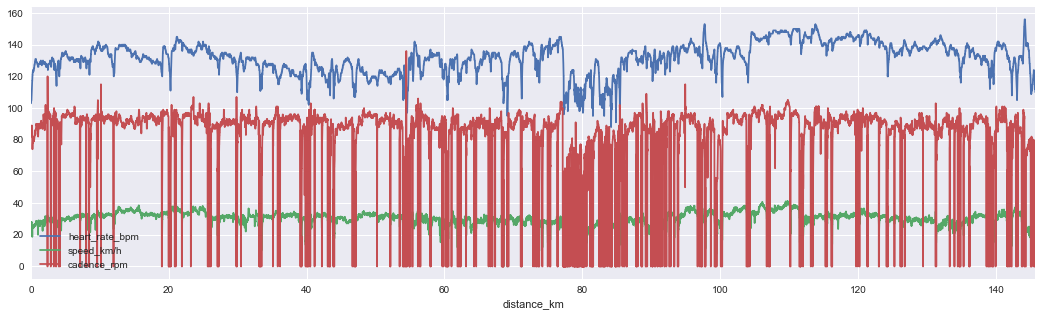

In [9]:
%matplotlib inline
df[['distance_km','heart_rate_bpm','speed_km/h','cadence_rpm']].plot(figsize=(18,5),x='distance_km')

In [10]:
week = df[['distance_km','heart_rate_bpm','speed_km/h','cadence_rpm']]

p = figure(x_axis_type="linear", title="training data", plot_height=350, plot_width=950)
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Distance'
p.yaxis.axis_label = 'Value'

p.line(week.distance_km, week.heart_rate_bpm)
p.line(week.distance_km, week['speed_km/h'],line_color='green')
p.line(week.distance_km, week.cadence_rpm,line_color='red')

show(p)

In [11]:
import folium

In [12]:
points = df['coordinates'].values.tolist()
ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)
 
# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=10)

# add Markers
i=0
for km_marker in km_markers:
    ic = folium.Icon(icon="bicycle",prefix="fa",color="blue",text="km" + str(i*10) + "")
    #ic = folium.features.DivIcon(html="<p style='color: blue'>km</br><b>" + str(i*10) + "</b></p>", icon_size=10, icon_anchor=None, popup_anchor=None, class_name='empty')
    pu = folium.map.Popup(html="<p>km</br><b>" + str(i*10) + "</b></p>", parse_html=False, max_width='50%', show=False, sticky=False)
    folium.Marker(km_marker,popup=pu,icon=ic).add_to(my_map)
    i=i+1
    
#fadd lines
folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(my_map)
my_map